Resource used for this notebook: https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [45]:
import os.path
import re
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import pandas as pd
import langdetect as ld

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tiern\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    text=""
    with open( os.path.join(path, file_name),"r", encoding="utf8") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles

In [47]:
def preprocess_data(doc_set):
    """
    Input  : document list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english')+["http"])
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [48]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [49]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [50]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [51]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [52]:
def removeFromText(pattern, series, space=""):
    return series.apply(lambda s: re.sub(pattern, space, str(s) ))

In [53]:
def cleanText(df):
    patternLinks = "http.*"
    patternAts = "@.*"
    patternNewLine = "\n"
    df['text'] = removeFromText(patternLinks, df['text'])
    df['text'] = removeFromText(patternAts, df['text'])
    df['text'] = removeFromText(patternNewLine, df['text'], " ")

In [54]:
def getLangs(df):
    langs = []
    for text in df['text']:
        l = ""
        try:
            l = ld.detect(text)
        except:
            l = "error"
        langs.append(l)
    df['langs'] = langs

# Clean the Tweets

In [55]:
df1 = pd.read_csv("first_pull.csv")
df2 = pd.read_csv("second_pull.csv")
df3 = pd.read_csv("thirdpull_earlyLockdown.csv")
df4 = pd.read_csv("fourthpull_midLockdown.csv")
df5 = pd.read_csv("May_data.csv")
df6 = pd.read_csv("June_data.csv")

In [58]:
each = (df1, df2, df3, df4, df5, df6)
DF = pd.concat(each, ignore_index=True)

In [67]:
getLangs(DF)
DF = DF[DF['langs'] == 'en']

In [60]:
patternLinks = "http.*"
patternAts = "@.*"
patternNewLine = "\n"
DF['text'] = removeFromText(patternLinks, DF['text'])
DF['text'] = removeFromText(patternAts, DF['text'])
DF['text'] = removeFromText(patternNewLine, DF['text'], " ")

# With Gensim

In [61]:
def model(tweets, words=8, number_of_topics=3):
    model=create_gensim_lsa_model(tweets,number_of_topics,words)

# Topic Coherence
Topic coherence provides a quantity that tells us the extent that the main words in a given topic are semantically related.  

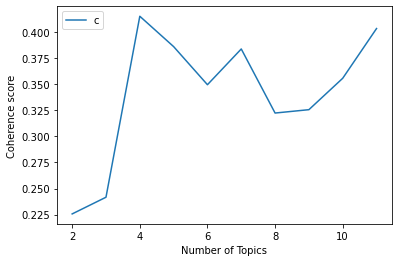

In [62]:
all_tweets = preprocess_data(DF['text'])
start,stop,step=2,12,1
plot_graph(all_tweets,start,stop,step)

In [19]:
model(all_tweets, 10, 6)

[(0, '0.648*"covid" + 0.639*"19" + 0.195*"coronaviru" + 0.141*"case" + 0.107*"test" + 0.089*"trump" + 0.081*"new" + 0.062*"death" + 0.062*"posit" + 0.060*"peopl"'), (1, '-0.870*"coronaviru" + 0.226*"covid" + 0.224*"19" + -0.165*"case" + -0.135*"trump" + -0.084*"new" + -0.073*"test" + -0.063*"report" + -0.063*"death" + -0.060*"peopl"'), (2, '0.725*"case" + 0.338*"new" + -0.294*"trump" + -0.180*"coronaviru" + 0.172*"report" + 0.138*"1" + 0.123*"day" + 0.108*"death" + -0.088*"test" + 0.087*"state"'), (3, '0.763*"trump" + -0.290*"coronaviru" + 0.219*"presid" + 0.219*"test" + 0.207*"case" + 0.157*"new" + -0.104*"19" + 0.102*"donald" + 0.094*"tulsa" + -0.084*"covid"'), (4, '-0.364*"corona" + 0.354*"test" + -0.335*"amp" + -0.314*"go" + -0.278*"viru" + -0.208*"shit" + -0.195*"children" + 0.192*"posit" + -0.186*"sit" + -0.185*"expos"'), (5, '0.691*"test" + 0.373*"posit" + -0.284*"trump" + 0.190*"corona" + 0.166*"amp" + 0.138*"go" + 0.136*"viru" + 0.113*"staff" + 0.104*"shit" + 0.101*"children"'

# Breaking it down with Sklearn

Resource: https://www.datascienceassn.org/sites/default/files/users/user1/lsa_presentation_final.pdf

In [63]:
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import numpy

In [64]:
stops = set(stopwords.words('english')+["http"])

In [65]:
vectorizer = CountVectorizer(min_df=1, stop_words=stops)
docTermMatrix = vectorizer.fit_transform(DF['text'])
dtm = pd.DataFrame(docTermMatrix.toarray(), index=DF['text'], columns=vectorizer.get_feature_names())

In [66]:
dtm.head()

,00,000,000marks,033k,070,10,100,1003,100b,100daysofcode,...,zone,إختبار,كورونا,للبشرية,هو,والإنسانية,パンデミックとウォール街の関係ーーspecial,𝗔𝗥𝗘,𝗟𝗜𝗩𝗘,𝗪𝗘
text,,,,,,,,,,,,,,,,,,,,,
#16 is my immune system fending off corona,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Everyone knows that we're facing a real crisis from the coronavirus. But do you know how we got here and what we ne…,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"""She tested for coronavirus, and her results were delayed. Five days later, she was dead in her kitchen."" She was 3…",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"The Goddard Report with host #CoronaVirus, #ToxicDrugs, and #FakeNews How to turn a non-pandemic int…",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Robert Reich says airlines ‘shouldn’t see a dime of taxpayer money’ in a coronavirus bailout,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Where SVD comes in...

"Sigma describes the relative strengths of the features. U describes the relationship between terms (rows) and features (columns). The transpose of V describes the relationship between features and documents (columns)." - https://matpalm.com/lsa_via_svd/eg1.html

In [33]:
lsa = TruncatedSVD(4, algorithm='randomized')
dtm_lsa = lsa.fit_transform(docTermMatrix) # From doc: Fit model to X and perform dimensionality reduction on X.
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa) #Normalizes samples to unit norm

"Scaling inputs to unit norms is a common operation for text classification or clustering for instance. For instance the dot product of two l2-normalized TF-IDF vectors is the cosine similarity of the vectors and is the base similarity metric for the Vector Space Model commonly used by the Information Retrieval community." - sklearn documenation for Normalizer

In [34]:
resultsDF = pd.DataFrame(lsa.components_,index = ["component_1","component_2", "component_3", "component_4"],columns = vectorizer.get_feature_names())

In [35]:
resultsDF

,00,000,000marks,033k,070,10,100,1003,100b,100daysofcode,...,zone,إختبار,كورونا,للبشرية,هو,والإنسانية,パンデミックとウォール街の関係ーーspecial,𝗔𝗥𝗘,𝗟𝗜𝗩𝗘,𝗪𝗘
component_1,0.000051,0.042568,0.000106,0.000942,0.000903,0.010054,0.004568,0.000026,0.000153,0.001162,...,0.002483,0.000025,0.000051,0.000025,0.000025,0.000025,0.000158,0.001127,0.001127,0.001127
component_2,0.000080,0.057168,0.000222,0.003667,0.004834,0.012601,0.006893,0.000015,0.001265,-0.000328,...,0.000662,0.000039,0.000079,0.000039,0.000039,0.000039,0.001264,-0.000431,-0.000431,-0.000431
component_3,0.000340,0.072755,0.002570,0.006825,0.004592,0.015856,0.014037,-0.000079,-0.000379,0.001005,...,-0.002736,0.000004,0.000007,0.000004,0.000004,0.000004,-0.000633,-0.000431,-0.000431,-0.000431
component_4,0.000212,0.026993,0.001250,0.001187,-0.001553,0.004943,0.019228,0.000027,-0.001091,0.000300,...,0.001419,0.000165,0.000330,0.000165,0.000165,0.000165,-0.001062,-0.000701,-0.000701,-0.000701


In [69]:
vectorizer = CountVectorizer(min_df=1, stop_words=stops)
exampleTweets = vectorizer.fit_transform(DF['text'][0:10])

In [70]:
from sklearn.utils.extmath import randomized_svd

In [75]:
U, Sigma, Vt = randomized_svd(exampleTweets.toarray(), n_components = 2)

# Matrix U
Below we have our matrix U.  In our application, U contains the word assignment to topics.  The columns of U represent the topics present among the tweets.  The rows are comprised of a score designating how the respective term fits within the topic.

In [87]:
pd.DataFrame(U, index=DF['text'][0:10], columns=['Topic 1', 'Topic 2'])

,Topic 1,Topic 2
text,,
#16 is my immune system fending off corona,0.000000e+00,0.000000e+00
Everyone knows that we're facing a real crisis from the coronavirus. But do you know how we got here and what we ne…,-2.969847e-15,3.215273e-01
"""She tested for coronavirus, and her results were delayed. Five days later, she was dead in her kitchen."" She was 3…",-2.235191e-15,3.215273e-01
"The Goddard Report with host #CoronaVirus, #ToxicDrugs, and #FakeNews How to turn a non-pandemic int…",-3.319393e-15,4.195837e-01
Robert Reich says airlines ‘shouldn’t see a dime of taxpayer money’ in a coronavirus bailout,-3.663736e-15,3.668951e-01
Coronavirus is spreading fear. Morrison could solve this with the stroke of a pen. People trust Bowtell and Swan t…,-4.378442e-15,5.111400e-01
Trump finds a way to sprinkle some racism on the coronavirus pandemic. Full episode:,-2.955969e-15,3.734102e-01
The Police in London are trying to brighten the mood. The are going up and down the Thames in a police boat playin…,-8.360933e-15,-1.582068e-15
"Observance of World Oral Health Day at Wokha town by Indian Dental Association, wokha branch on March 20. Leaflets…",1.000000e+00,8.253814e-15


# Matrix Sigma
Below we have our Sigma, which we know consists the singular value of our term document matrix.  In our application, the singular values represent the topic importances.  The matrix provides an idea of how prevalent each topic is amongst the documents.

In [88]:
pd.DataFrame(Sigma, index=['Topic 1', 'Topic 2'], columns=['Topic Importance'])

,Topic Importance
Topic 1,4.123106
Topic 2,4.010875


# Matrix transpose V
V tranpose represents the distribution of topics accross our tweets.

In [92]:
pd.DataFrame(Vt, columns=vectorizer.get_feature_names())

,16,20,airlines,association,bailout,boat,bowtell,branch,brighten,certain,...,town,toxicdrugs,trump,trust,trying,turn,wants,way,wokha,world
0,1.170938e-17,2.425356e-01,-8.523659e-16,2.425356e-01,-8.560522e-16,-2.103559e-15,-1.132293e-15,2.425356e-01,-2.101878e-15,-5.882441e-16,...,2.425356e-01,-7.798056e-16,-6.844026e-16,-1.132944e-15,-2.103803e-15,-7.798056e-16,-5.885710e-16,-6.844026e-16,4.850713e-01,2.425356e-01
1,-3.621235e-17,2.032165e-15,9.147509e-02,2.019780e-15,9.147509e-02,-3.584186e-16,1.274385e-01,2.015618e-15,-3.640006e-16,7.134217e-02,...,2.011796e-15,1.046115e-01,9.309945e-02,1.274385e-01,-3.577935e-16,1.046115e-01,7.134217e-02,9.309945e-02,4.023592e-15,2.011796e-15
